## JOB-A-THON - September 2021 - Store Sales Prediction problem

### Notebook setup

In [0]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import mlflow
import mlflow.sklearn

In [0]:
# Setting pandas options for good visualization
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.max_info_columns', 30)

# seaborn style for chart visualization
sns.set_style("whitegrid")

### Creating datasets

In [0]:
# loading test dataset
# File location and type
file_location = "/FileStore/tables/TRAIN.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
train = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

train = train.toPandas()

### Data preprocessing

In [0]:
###################### data preprocessing - train #######################
# reordering columns of train dataset
train = \
train[["ID","Sales","Store_id","Store_Type",
       "Location_Type","Region_Code","Date","Holiday",
       "Discount","#Order"
           ]]

# renaming feature names
train = train.rename(columns={"#Order":"Num_Order"})

# changing variable type 
# Store id : int -> object
#train["Store_id"] = train["Store_id"].astype('object')
# Date id : object -> Date
train["Date"] = pd.to_datetime(train["Date"])

# Recoding Discount column
discount = {"Yes":1, "No":0}
train["Discount"] = train["Discount"].map(discount)

###################### feature engineering - train #####################
# Creating date time features
train["Year"]= train["Date"].dt.year
train["Month"]= train["Date"].dt.month
train["Day"]= train["Date"].dt.day
train["Week_of_year"] = train["Date"].dt.week
train["Day_of_week"] = train["Date"].dt.dayofweek
train["Weekend"] = np.where(train["Day_of_week"].isin([5,6]), 1, 0)
train["Month_Start"] = train["Date"].dt.is_month_start.astype(int)
train["Month_End"] = train["Date"].dt.is_month_end.astype(int)
train["Quarter_Start"] = train["Date"].dt.is_quarter_start.astype(int)
train["Quarter_End"] = train["Date"].dt.is_quarter_end.astype(int)
train["Year_Start"] = train["Date"].dt.is_year_start.astype(int)
train["Year_End"] = train["Date"].dt.is_year_end.astype(int)
train['Period'] = train['Date'].dt.strftime('%Y%m').astype(int)

<command-4185058902830891>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train["Week_of_year"] = train["Date"].dt.week


### Exploratory daya analysis

#### Glimpse of data

In [0]:
# Shape of data
print("Shape of training data :", train.shape)
print("")

# variable type - train
print("data info - train")
print(train.info())
print("")

# unique values - train
print("unique values - train")
print(train.nunique())
print("")

# missing %
print("Missing % in training data :", '{:.1%}'.format(train.isnull().sum().sum()/len(train)))

Shape of training data : (188340, 23)

data info - train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Sales          188340 non-null  float64       
 2   Store_id       188340 non-null  int32         
 3   Store_Type     188340 non-null  object        
 4   Location_Type  188340 non-null  object        
 5   Region_Code    188340 non-null  object        
 6   Date           188340 non-null  datetime64[ns]
 7   Holiday        188340 non-null  int32         
 8   Discount       188340 non-null  int64         
 9   Num_Order      188340 non-null  int32         
 10  Year           188340 non-null  int64         
 11  Month          188340 non-null  int64         
 12  Day            188340 non-null  int64         
 13  Week_of_year   188340 non-null  int64         


In [0]:
# top 5 rows
train.head()

,ID,Sales,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Num_Order,Year,Month,Day,Week_of_year,Day_of_week,Weekend,Month_Start,Month_End,Quarter_Start,Quarter_End,Year_Start,Year_End,Period
0,T1000001,"7,011.84",1,S1,L3,R1,2018-01-01,1,1,9,2018,1,1,1,0,0,1,0,1,0,1,0,201801
1,T1000002,"51,789.12",253,S4,L2,R1,2018-01-01,1,1,60,2018,1,1,1,0,0,1,0,1,0,1,0,201801
2,T1000003,"36,868.20",252,S3,L2,R1,2018-01-01,1,1,42,2018,1,1,1,0,0,1,0,1,0,1,0,201801
3,T1000004,"19,715.16",251,S2,L3,R1,2018-01-01,1,1,23,2018,1,1,1,0,0,1,0,1,0,1,0,201801
4,T1000005,"45,614.52",250,S2,L3,R4,2018-01-01,1,1,62,2018,1,1,1,0,0,1,0,1,0,1,0,201801


In [0]:
# bottom 5 rows
train.tail()

,ID,Sales,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Num_Order,Year,Month,Day,Week_of_year,Day_of_week,Weekend,Month_Start,Month_End,Quarter_Start,Quarter_End,Year_Start,Year_End,Period
188335,T1188336,"37,272.00",149,S2,L3,R2,2019-05-31,1,1,51,2019,5,31,22,4,0,0,1,0,0,0,0,201905
188336,T1188337,"54,572.64",153,S4,L2,R1,2019-05-31,1,0,90,2019,5,31,22,4,0,0,1,0,0,0,0,201905
188337,T1188338,"31,624.56",154,S1,L3,R2,2019-05-31,1,0,56,2019,5,31,22,4,0,0,1,0,0,0,0,201905
188338,T1188339,"49,162.41",155,S3,L1,R2,2019-05-31,1,1,70,2019,5,31,22,4,0,0,1,0,0,0,0,201905
188339,T1188340,"37,977.00",152,S2,L1,R1,2019-05-31,1,0,47,2019,5,31,22,4,0,0,1,0,0,0,0,201905


#### Univariate analysis

In [0]:
# Basic statistics
descriptive_stats_Sales = train.Sales.describe().reset_index()
descriptive_stats_Sales.columns = ["Statistics", "Value"]

# Skewness and kurtosis
cv_skewness_kurt = \
    pd.DataFrame({"Statistics":["cv", "skewness", "kurtosis"],
                  "Value": [train.Sales.std()/train.Sales.mean(), 
                            train.Sales.skew(),train.Sales.kurt()]})

descriptive_stats_Sales = \
    pd.concat([descriptive_stats_Sales, cv_skewness_kurt])

print(descriptive_stats_Sales)

  Statistics      Value
0      count 188,340.00
1       mean  42,784.33
2        std  18,456.71
3        min       0.00
4        25%  30,426.00
5        50%  39,678.00
6        75%  51,909.00
7        max 247,215.00
0         cv       0.43
1   skewness       1.25
2   kurtosis       3.49


/databricks/python/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


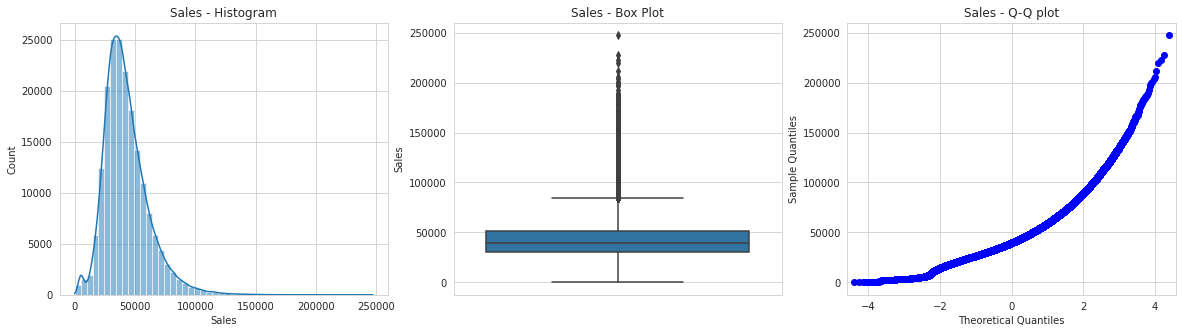

In [0]:
# histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
sns.histplot(x = train["Sales"], bins=50, kde = True, ax= ax1);
ax1.set_title("Sales - Histogram")
sns.boxplot(y = train["Sales"], ax= ax2);
ax2.set_title("Sales - Box Plot");
sm.qqplot(train["Sales"], ax = ax3)
ax3.set_title("Sales - Q-Q plot");
plt.show();

*****
Based on descriptive statistics and visual analysis of **Sales**, we can deduce that: 
 + Average Sales is 42,784.33 which is higher than Median Sales 39,678 indicating presence of some high outlier sales.
 + Standard Deviation of 18,456.71 and coefficient of variation equals to 0.43 indicate moderate noise in Sales.
 + Zero sales recorded for some stores whereas Maximum Sales recorded around 247,215 which is more than Average + 3 * std indicating presence of extreme outliers.
 + Skewness score of 1.25 indicates Sales is positively skewed. This is also confirmed by histogram of Sales.
 + Based on Graphical analysis, we can deduce that Sales is not following normal distribution. It is right skewed with heavy tail influenced by presence of high sales in some stores or day.
 *****

In [0]:
# splitting variables into separate categories
cont_cols = ["Num_Order"]
cat_cols_high_card = ["Store_id"]
binary_cols = ["Holiday", "Discount", "Weekend", "Month_Start", "Month_End",
               "Quarter_Start", "Quarter_End", "Year_Start", "Year_End"]
cat_cols = ["Store_Type", "Location_Type", "Region_Code"]
date_cols = ["Year", "Month", "Day", "Week_of_year", "Day_of_week"]

  Statistics      Value
0      count 188,340.00
1       mean      68.21
2        std      30.47
3        min       0.00
4        25%      48.00
5        50%      63.00
6        75%      82.00
7        max     371.00
0         cv       0.45
1   skewness       1.37
2   kurtosis       3.68
/databricks/python/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


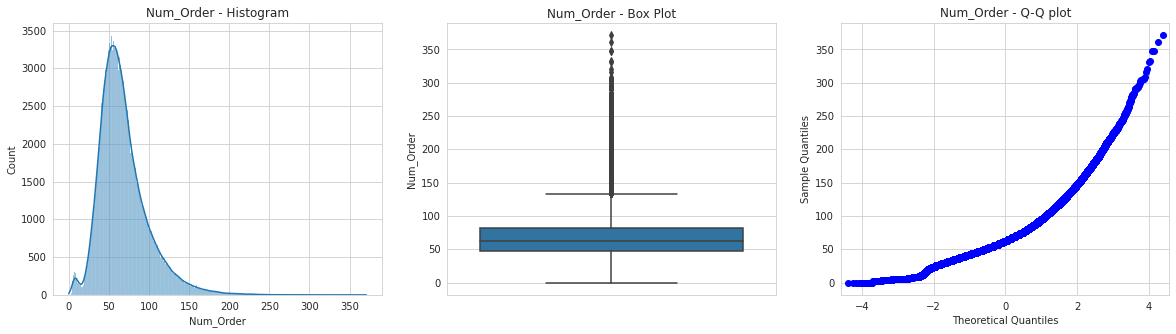

In [0]:
# Num_Order
# Basic statistics
descriptive_stats_Sales = train.Num_Order.describe().reset_index()
descriptive_stats_Sales.columns = ["Statistics", "Value"]

# Skewness and kurtosis
cv_skewness_kurt = \
    pd.DataFrame({"Statistics":["cv", "skewness", "kurtosis"],
                  "Value": [train.Num_Order.std()/train.Num_Order.mean(), 
                            train.Num_Order.skew(),train.Num_Order.kurt()]})

descriptive_stats_Sales = \
    pd.concat([descriptive_stats_Sales, cv_skewness_kurt])

print(descriptive_stats_Sales)
# histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
sns.histplot(x = train["Num_Order"], discrete=True, kde = True, ax= ax1);
ax1.set_title("Num_Order - Histogram")
sns.boxplot(y = train["Num_Order"], ax= ax2);
ax2.set_title("Num_Order - Box Plot");
sm.qqplot(train["Num_Order"], ax = ax3)
ax3.set_title("Num_Order - Q-Q plot");
plt.show();

In [0]:
# Store_id - Frequency analysis
print(train["Store_id"].value_counts())

128    516
84     516
211    516
83     516
338    516
      ... 
168    516
40     516
295    516
167    516
255    516
Name: Store_id, Length: 365, dtype: int64


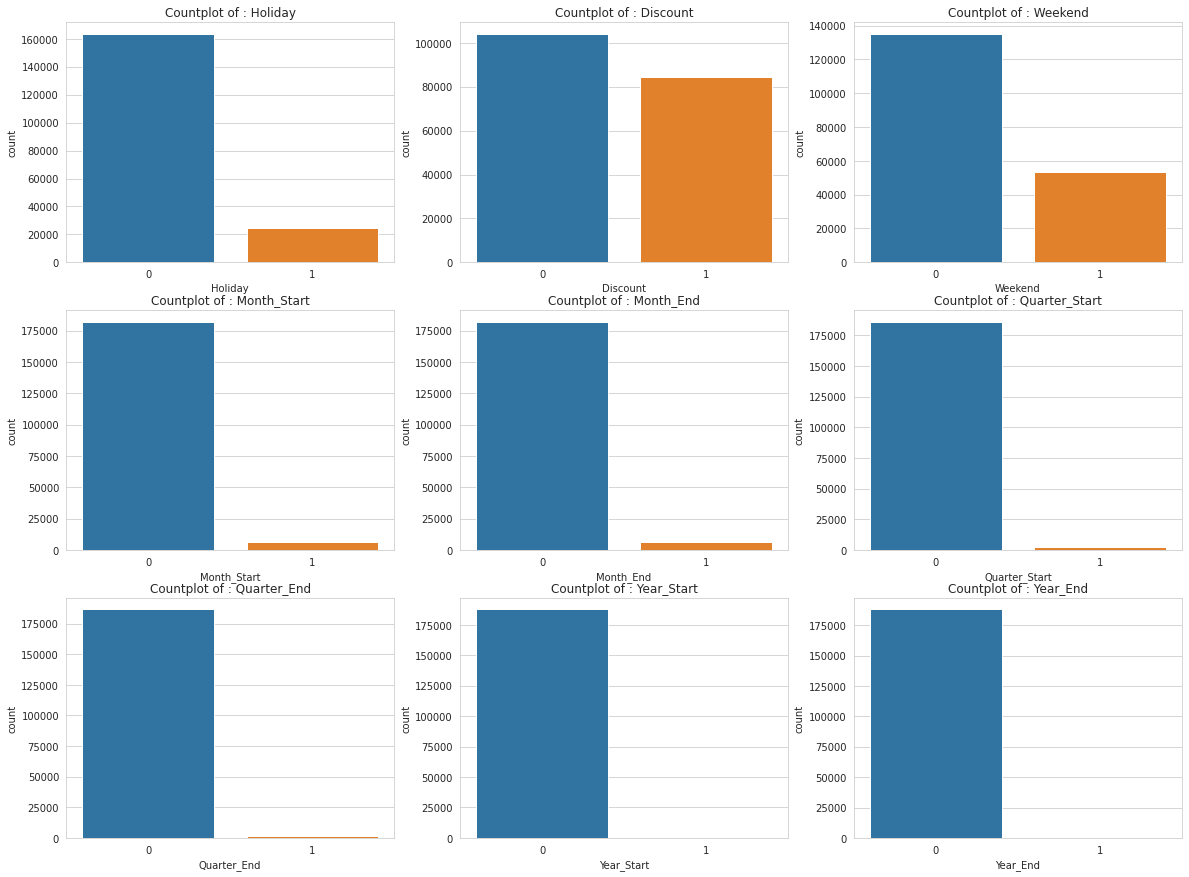

In [0]:
# Binary columns - Countplot
count=1
plt.subplots(figsize=(20, 15))
for col in binary_cols:
    plt.subplot(3,3,count)
    sns.countplot(x=col, data = train)
    plt.title("Countplot of : " +  col)
    count+=1

plt.show()

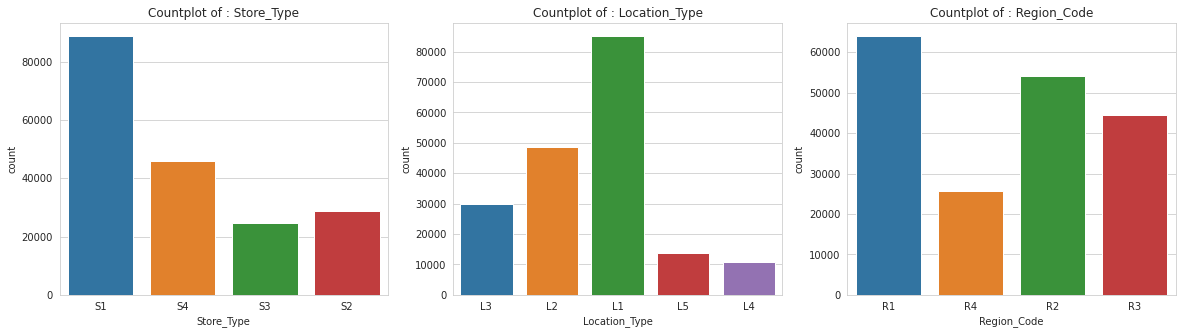

In [0]:
# Categorical columns - Countplot
count=1
plt.subplots(figsize=(20, 5))
for col in cat_cols:
    plt.subplot(1,3,count)
    sns.countplot(x=col, data = train)
    plt.title("Countplot of : " +  col)
    count+=1

plt.show()

In [0]:
# Date columns : Frequency analysis
for col in date_cols:
    print("Frequency analysis of : " + col)
    print(train[col].value_counts().sort_index())

Frequency analysis of : Year
2018    133225
2019     55115
Name: Year, dtype: int64
Frequency analysis of : Month
1     22630
2     20440
3     22630
4     21900
5     22630
6     10950
7     11315
8     11315
9     10950
10    11315
11    10950
12    11315
Name: Month, dtype: int64
Frequency analysis of : Day
1     6205
2     6205
3     6205
4     6205
5     6205
6     6205
7     6205
8     6205
9     6205
10    6205
11    6205
12    6205
13    6205
14    6205
15    6205
16    6205
17    6205
18    6205
19    6205
20    6205
21    6205
22    6205
23    6205
24    6205
25    6205
26    6205
27    6205
28    6205
29    5475
30    5475
31    3650
Name: Day, dtype: int64
Frequency analysis of : Week_of_year
1     5110
2     5110
3     5110
4     5110
5     5110
      ... 
48    2555
49    2555
50    2555
51    2555
52    2555
Name: Week_of_year, Length: 52, dtype: int64
Frequency analysis of : Day_of_week
0    27010
1    27010
2    27010
3    27010
4    27010
5    26645
6    26645
Name: D

#### Bivariate analysis

Pearson Correlation between Sales and Order : 0.94
Spearman's rho between Sales and Order : 0.94
Kendall's tau between Sales and Order : 0.79


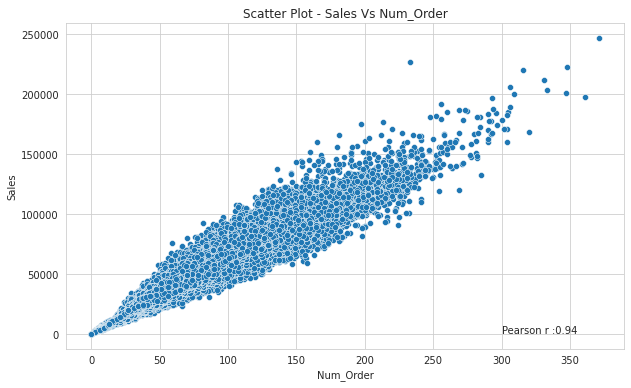

In [0]:
# Correlation analysis
print("Pearson Correlation between Sales and Order :", \
    train["Num_Order"].corr(train["Sales"]).round(2))
print("Spearman's rho between Sales and Order :", \
    train["Num_Order"].corr(train["Sales"], method='spearman').round(2))
print("Kendall's tau between Sales and Order :", \
    train["Num_Order"].corr(train["Sales"], method='kendall').round(2))

# Scatterplot
plt.figure(figsize = (10,6))
plt.title("Scatter Plot - Sales Vs Num_Order")
plt.text(300,500, "Pearson r :"+ str(train["Num_Order"].corr(train["Sales"]).round(2)))
sns.scatterplot(x="Num_Order", y="Sales", data = train);
plt.show();

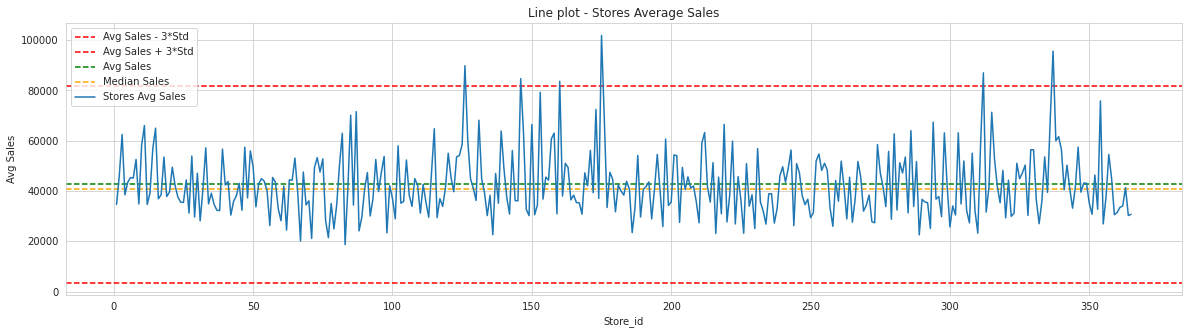

In [0]:
# Line plot - Stores vs Avg Sales
plt.figure(figsize = (20,5))
plt.title("Line plot - Stores Average Sales")
stores_avgsales = train.groupby("Store_id")["Sales"].mean().reset_index()
stores_avgsales.columns = ["Store_id", "Avg Sales"]
plt.axhline(y=stores_avgsales["Avg Sales"].mean()-3*stores_avgsales["Avg Sales"].std(), 
color='r', linestyle='--', label = "Avg Sales - 3*Std")
plt.axhline(y=stores_avgsales["Avg Sales"].mean()+3*stores_avgsales["Avg Sales"].std(), 
color='r', linestyle='--', label = "Avg Sales + 3*Std")
plt.axhline(y=stores_avgsales["Avg Sales"].mean(), color='g', linestyle='--', label = "Avg Sales")
plt.axhline(y=stores_avgsales["Avg Sales"].median(), color='orange', linestyle='--', label = "Median Sales")
sns.lineplot(x="Store_id", y = "Avg Sales", data = stores_avgsales, label = "Stores Avg Sales")
plt.legend()
plt.show();

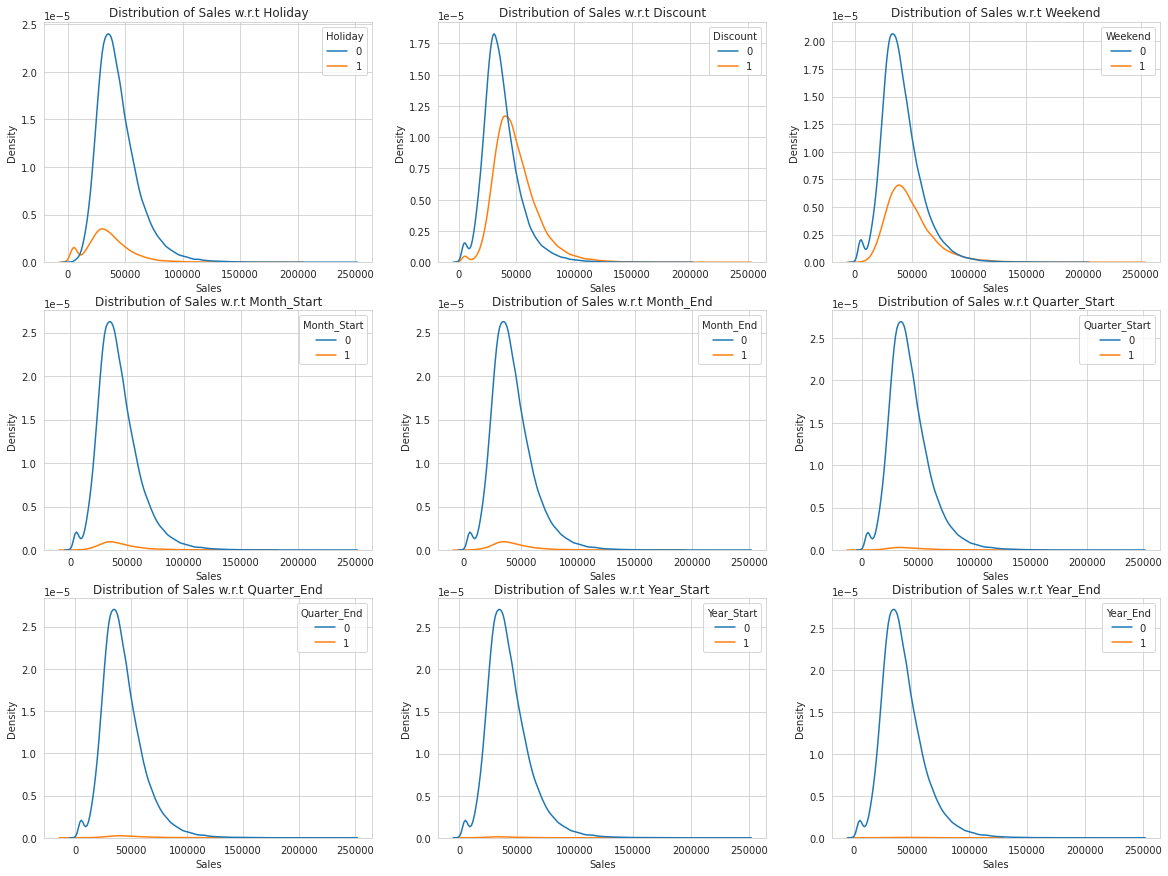

In [0]:
# Binary columns Vs Sales - kdeplot
count=1
plt.subplots(figsize=(20, 15))
for col in binary_cols:
    plt.subplot(3,3,count)
    sns.kdeplot(x="Sales", hue = col, data = train)
    plt.title("Distribution of Sales w.r.t " +  col)
    count+=1

plt.show()

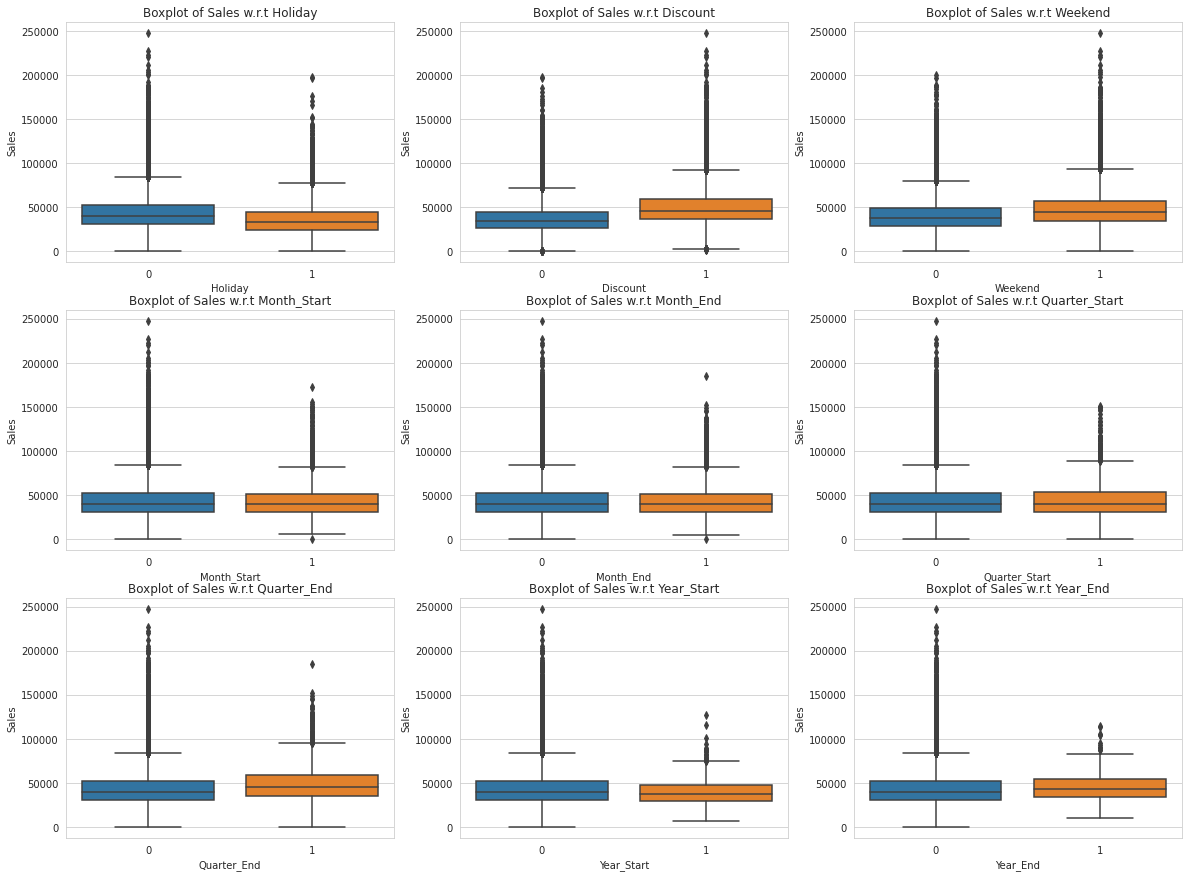

In [0]:
# Binary columns Vs Sales - boxplot
count=1
plt.subplots(figsize=(20, 15))
for col in binary_cols:
    plt.subplot(3,3,count)
    sns.boxplot(x = col, y ="Sales", data = train)
    plt.title("Boxplot of Sales w.r.t " +  col)
    count+=1

plt.show()

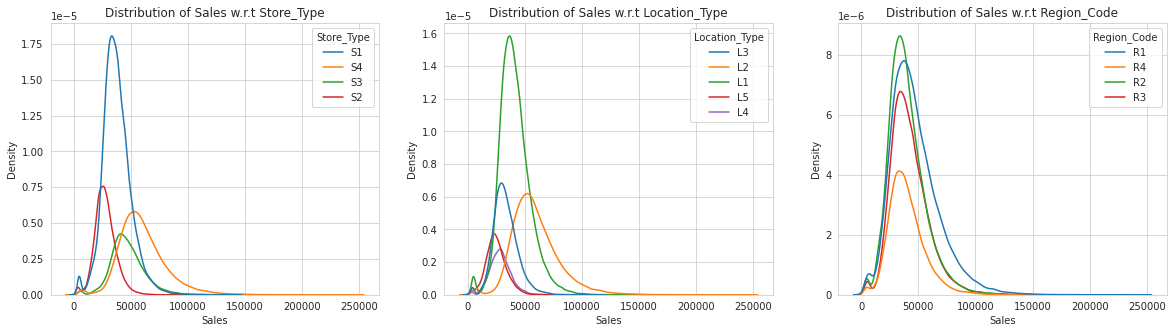

In [0]:
# Categorical columns Vs Sales - kdeplot
count=1
plt.subplots(figsize=(20, 5))
for col in cat_cols:
    plt.subplot(1,3,count)
    sns.kdeplot(x="Sales", hue = col, data = train)
    plt.title("Distribution of Sales w.r.t " +  col)
    count+=1

plt.show()

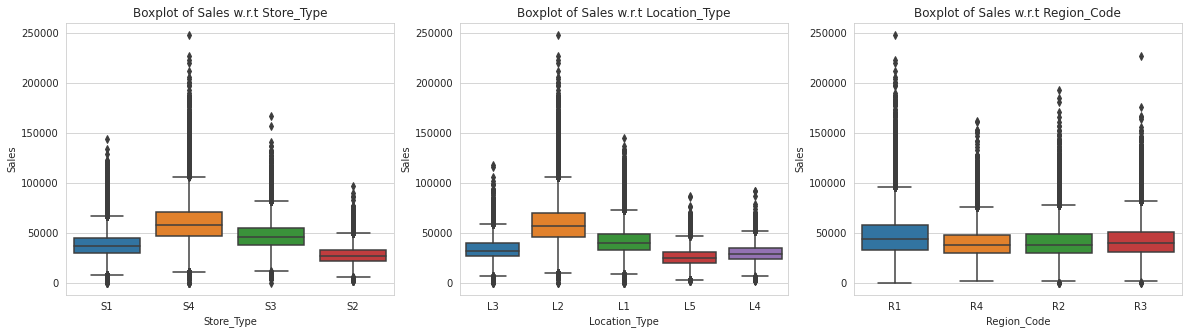

In [0]:
# Categorical columns Vs Sales - boxplot
count=1
plt.subplots(figsize=(20, 5))
for col in cat_cols:
    plt.subplot(1,3,count)
    sns.boxplot(x = col, y ="Sales", data = train)
    plt.title("Boxplot of Sales w.r.t " +  col)
    count+=1

plt.show()

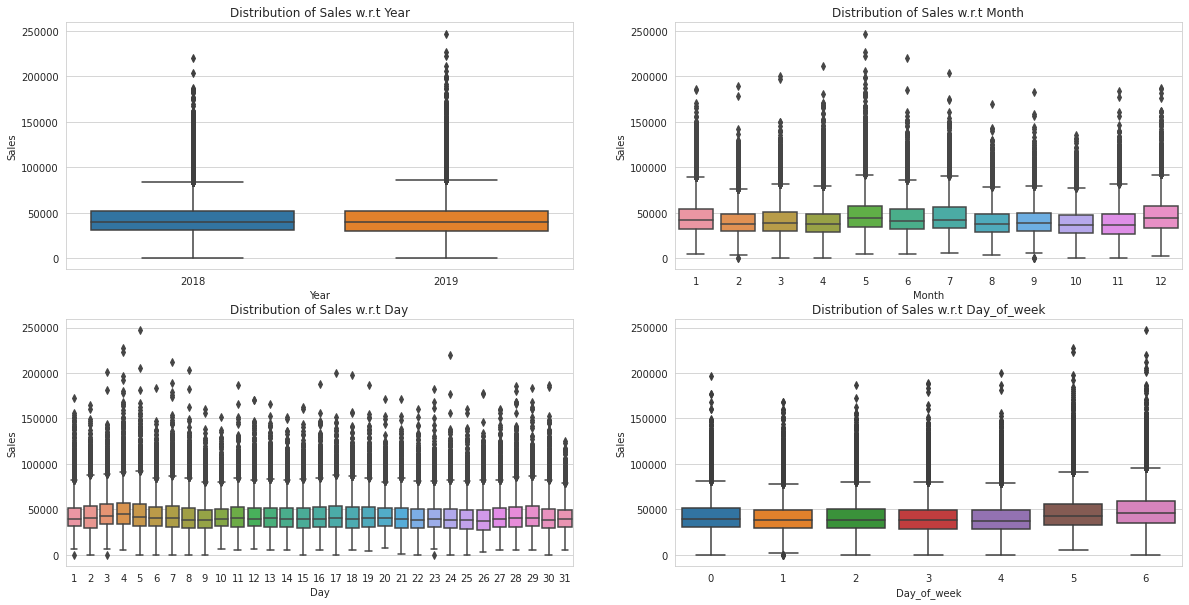

In [0]:
# Date indicator columns Vs Sales - Boxplot
date_cols_rev = ["Year", "Month", "Day", "Day_of_week"]
count=1
plt.subplots(figsize=(20, 10))
for col in date_cols_rev:
    plt.subplot(2,2,count)
    sns.boxplot(y="Sales", x = col, data = train)
    plt.title("Distribution of Sales w.r.t " +  col)
    count+=1

plt.show()

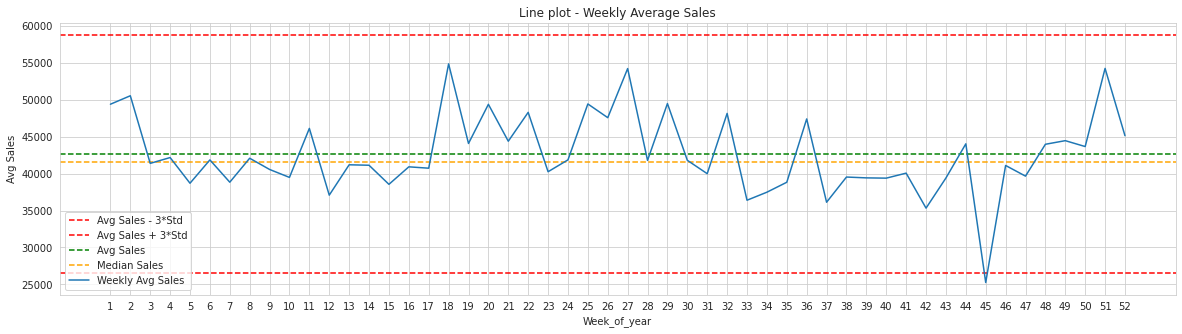

In [0]:
# Line plot - Weekly Avg Sales
plt.figure(figsize = (20,5))
plt.title("Line plot - Weekly Average Sales")
weekly_avgsales = train.groupby("Week_of_year")["Sales"].mean().reset_index()
weekly_avgsales.columns = ["Week_of_year", "Avg Sales"]
plt.axhline(y=weekly_avgsales["Avg Sales"].mean()-3*weekly_avgsales["Avg Sales"].std(), 
color='r', linestyle='--', label = "Avg Sales - 3*Std")
plt.axhline(y=weekly_avgsales["Avg Sales"].mean()+3*weekly_avgsales["Avg Sales"].std(), 
color='r', linestyle='--', label = "Avg Sales + 3*Std")
plt.axhline(y=weekly_avgsales["Avg Sales"].mean(), color='g', linestyle='--', label = "Avg Sales")
plt.axhline(y=weekly_avgsales["Avg Sales"].median(), color='orange', linestyle='--', label = "Median Sales")
sns.lineplot(x="Week_of_year", y = "Avg Sales", data = weekly_avgsales, label = "Weekly Avg Sales")
plt.xticks(weekly_avgsales["Week_of_year"].unique().tolist())
plt.legend()
plt.show();

### Model building

#### Feature engineering

In [0]:
# One-Hot Encoding (Dummy Encoding)
ohe_cols = ["Store_Type", "Location_Type", "Region_Code", "Day_of_week"]
train["Day_of_week"] = train["Day_of_week"].astype(object)
train = \
pd.concat([train.drop(ohe_cols, axis = 1), 
           pd.get_dummies(train[ohe_cols], prefix = ohe_cols)], axis = 1)

In [0]:
# Creating new features : stores avg sales
train["Sales_Sqrt"] = np.sqrt(train["Sales"].values)
Stores_avg_sales = train.groupby("Store_id")["Sales_Sqrt"].mean().reset_index()
Stores_avg_sales.columns = ["Store_id", "Avg_Sales_Sqrt"]
train = pd.merge(train, Stores_avg_sales, on = "Store_id", how = "left")

#### Creating X and y

In [0]:
# Creating X and y
X_train = train.drop(["ID", "Sales", "Sales_Sqrt", "Date", "Num_Order", "Period"], axis = 1)
y_train = train["Sales"].values
  
# transforming target variable using sqrt transformation
y_train_sq_trans = np.sqrt(y_train)

print("Shape of X_train :", X_train.shape)
print("Shape of y_train :", y_train_sq_trans.shape)

Shape of X_train : (188340, 35)
Shape of y_train : (188340,)


#### Fit model

training score : 36.700306862794235


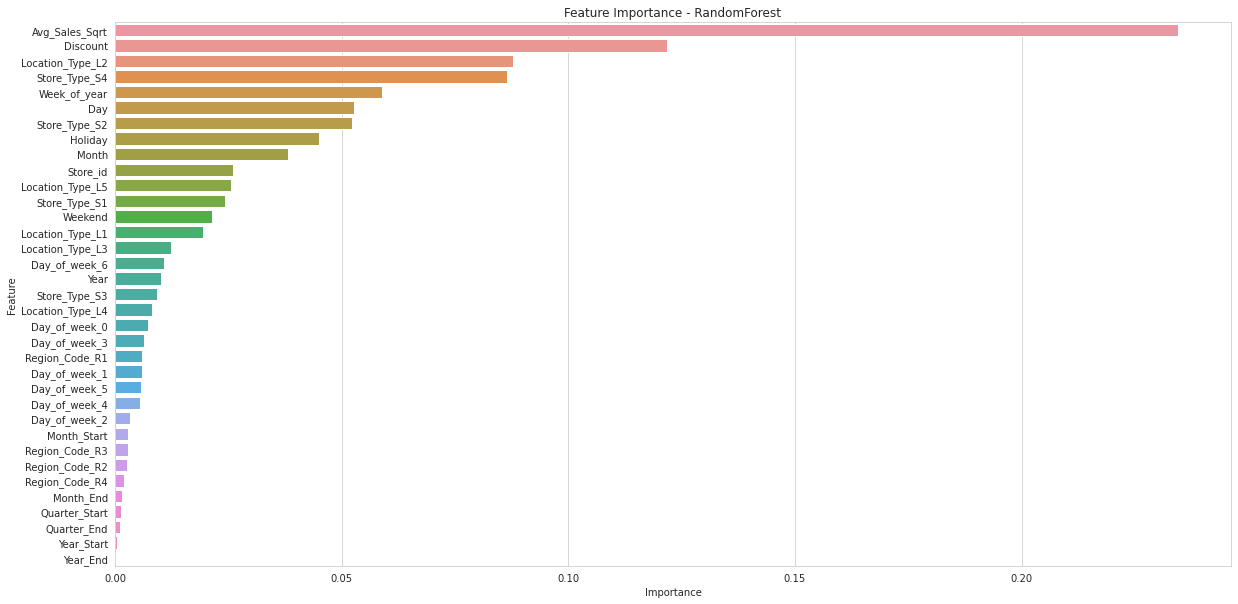

In [0]:
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "tuned_random_forest_sqrt_transformed"):
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  
  # calculating training score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  print("training score :", train_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

### Making prediction for future dates

In [0]:
# loading test dataset
# File location and type
file_location = "/FileStore/tables/TEST_FINAL.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
test = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

test = test.toPandas()

###################### data preprocessing - tets ########################

# changing variable type 
# Store id : int -> object
# test["Store_id"] = test["Store_id"].astype('object')
# Date id : object -> Date
test["Date"] = pd.to_datetime(test["Date"])

# Recoding Discount column
discount = {"Yes":1, "No":0}
test["Discount"] = test["Discount"].map(discount)

###################### feature engineering - test #######################

test["Year"]= test["Date"].dt.year
test["Month"]= test["Date"].dt.month
test["Day"]= test["Date"].dt.day
test["Week_of_year"] = test["Date"].dt.week
test["Day_of_week"] = test["Date"].dt.dayofweek
test["Weekend"] = np.where(test["Day_of_week"].isin([5,6]), 1, 0)
test["Month_Start"] = test["Date"].dt.is_month_start.astype(int)
test["Month_End"] = test["Date"].dt.is_month_end.astype(int)
test["Quarter_Start"] = test["Date"].dt.is_quarter_start.astype(int)
test["Quarter_End"] = test["Date"].dt.is_quarter_end.astype(int)
test["Year_Start"] = test["Date"].dt.is_year_start.astype(int)
test["Year_End"] = test["Date"].dt.is_year_end.astype(int)
test['Period'] = test['Date'].dt.strftime('%Y%m').astype(int)

# One-Hot Encoding (Dummy Encoding)
ohe_cols = ["Store_Type", "Location_Type", "Region_Code", "Day_of_week"]
test["Day_of_week"] = test["Day_of_week"].astype(object)
test = \
    pd.concat([test.drop(ohe_cols, axis = 1), 
    pd.get_dummies(test[ohe_cols], prefix = ohe_cols)], axis = 1)

# Creating new features : stores avg sales
test = pd.merge(test, Stores_avg_sales, on = "Store_id", how = "left")

# Creating final feature set
X_new = test.drop(["ID", "Date", "Period"], axis = 1)
predictions = np.square(rf_reg_model.predict(X_new))

val_df_pred = test.copy()
val_df_pred["Sales"] = predictions
val_df_pred_fin = val_df_pred[["ID", "Sales"]]

<command-4185058902830892>:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test["Week_of_year"] = test["Date"].dt.week


In [0]:
display(val_df_pred_fin)

ID,Sales
T1188341,61483.45261166203
T1188342,43019.0946621292
T1188343,84034.30422839492
T1188344,39796.416155186525
T1188345,44416.361664783224
T1188346,100142.62738453026
T1188347,73401.69916116352
T1188348,52799.968056325866
T1188349,58565.77291637276
T1188350,36097.651212239274
